In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_csv(' ... ')

In [3]:
df.head(3)

,quote_number,timestamp,channel,region,dateofbirth,license_years,num_convictions,num_fault_claims,make,model,manfyear,purchaseyear,fuel_type,transmission_type,payment_plan,nature_of_use,overnightparking_loc,policy_start_date,premium,converted
0,20886,05/04/2019 10:34,Google,BRISTOL,01/12/1965,32.0,0,0,YAMAHA,MT-03,2008.0,2012.0,petrol,automatic,annual,social-domestic-pleasure(sdp),unsecured_car_park,22/04/2019,85.94,1
1,7708,25/04/2019 13:21,Go Compare,BRISTOL,01/07/1960,41.0,0,0,YAMAHA,XJR 1300,2012.0,2012.0,electric,manual,annual,sdp-plus-commuting,garage,12/05/2019,127.21,0
2,14029,27/04/2019 13:03,Money Supermarket,BRISTOL,08/12/1963,36.0,0,1,HONDA,CB 650F (86HP),2015.0,2017.0,petrol,manual,annual,sdp-plus-commuting,drive,01/05/2019,249.56,1


## Data summary

Let's check the shape of our data

In [4]:
print(f'The dataset has {df.shape[0]:d} observations and {df.shape[1]:d} features.')

The dataset has 100000 observations and 20 features.


And now let's check the type of the rest of the columns

In [5]:
df.dtypes

quote_number              int64
timestamp                object
channel                  object
region                   object
dateofbirth              object
license_years           float64
num_convictions           int64
num_fault_claims          int64
make                     object
model                    object
manfyear                float64
purchaseyear            float64
fuel_type                object
transmission_type        object
payment_plan             object
nature_of_use            object
overnightparking_loc     object
policy_start_date        object
premium                 float64
converted                 int64
dtype: object

We notice that we have 3 columns related to date and time but their variable type is object, so let's change that.

In [6]:
df['dateofbirth'] = pd.to_datetime(df['dateofbirth'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])

Let's obtain a summary about the numerical columns of the dataset

In [7]:
df.describe()

,quote_number,license_years,num_convictions,num_fault_claims,manfyear,purchaseyear,premium,converted
count,1.000000e+05,100000.000000,100000.000000,100000.000000,99993.000000,97544.000000,99998.000000,100000.000000
mean,6.248810e+06,25.115120,0.051080,0.298160,2011.609423,2015.025363,427.309153,0.343500
std,3.830217e+06,14.167082,0.220162,0.555755,5.513250,3.974439,267.346187,0.474879
min,7.708000e+03,0.000000,0.000000,0.000000,1937.000000,1971.000000,18.290000,0.000000
25%,2.880006e+06,13.000000,0.000000,0.000000,2008.000000,2014.000000,274.362500,0.000000
50%,5.949290e+06,25.000000,0.000000,0.000000,2013.000000,2016.000000,357.555000,0.000000
75%,9.142949e+06,37.000000,0.000000,0.000000,2016.000000,2018.000000,488.980000,1.000000
max,1.471137e+07,53.000000,1.000000,2.000000,2019.000000,2019.000000,7206.960000,1.000000


And for the categorical columns, let's print the number of unique variables and the most frequent ones.

In [8]:
for col in df.columns:
    if df[col].dtypes == object:
        print(df[col].name, ' ', df[col].nunique(),  ' ', df[col].mode().iloc[0])

channel   7   Money Supermarket
region   21   BRISTOL
make   188   VW
model   18133   FIESTA ZETEC
fuel_type   3   petrol
transmission_type   2   automatic
payment_plan   2   annual
nature_of_use   3   sdp-plus-commuting
overnightparking_loc   5   drive


## Missing values

From the summary table above we notice that not every single column has 10,000 entries. Let's check how many values are missing from our dataset

In [9]:
df.isna().sum().sum()

2473

So let's see the proportion of missing values from every column

In [10]:
#Obtain columns with missing values
col_miss_val = df.loc[:, df.isna().any()]
col_miss_val.isna().sum()/(len(col_miss_val))*100

make            0.004
model           0.004
manfyear        0.007
purchaseyear    2.456
premium         0.002
dtype: float64

The percentage of the numerical missing values is quite small and insignificant, therefore we can subsitute them with the column mean.

In [11]:
df = df.fillna(df.mean())

C:\Users\yy19812\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [12]:
df.isna().sum().sum()

8

In [13]:
df[df.isnull().any(axis=1)]

,quote_number,timestamp,channel,region,dateofbirth,license_years,num_convictions,num_fault_claims,make,model,manfyear,purchaseyear,fuel_type,transmission_type,payment_plan,nature_of_use,overnightparking_loc,policy_start_date,premium,converted
29598,679178,2019-05-02 22:48:00,Go Compare,LEICESTER,1995-03-21,5.0,0,0,NaN,NaN,2011.609423,2015.025363,diesel,manual,annual,social-domestic-pleasure(sdp),drive,2019-05-02,285.86,0
79627,2077301,2019-06-24 17:20:00,Go Compare,CAMBRIDGE,1970-11-25,28.0,0,0,NaN,NaN,2011.609423,2015.025363,diesel,automatic,annual,sdp-plus-business,secured_car_park,2019-07-13,418.62,0
84384,624544,2019-07-13 15:08:00,Confused,CARDIFF,1985-07-05,15.0,0,0,NaN,NaN,2011.609423,2015.025363,petrol,automatic,annual,sdp-plus-commuting,drive,2019-07-22,285.86,1
91809,1986296,2019-12-07 15:42:00,Money Supermarket,LEICESTER,1968-03-21,30.0,1,0,NaN,NaN,2011.609423,2015.025363,diesel,automatic,annual,sdp-plus-commuting,drive,2019-07-20,565.20,1


We cannot substitute the average values in categorical variables. Maybe we could substitute with the most common ones but that might cause some form of bias so it would be much better if we just remove these 4 observations.

In [14]:
df = df.dropna()

## Some Exploratory Data Analysis

Let's explore our data further. For instance, let's examine the age of the customers.

In [15]:
df['yearofbirth'] = pd.DatetimeIndex(df['dateofbirth']).year
df['age'] = datetime.datetime.now().year - df['yearofbirth']
print(f'The oldest person is {df.age.max():d} years old and the youngest one {df.age.min():d}.')

The oldest person is 72 years old and the youngest one 20.


Let's try to find out whether the age is related to some of the features.

In [16]:
def average(y):
    """This function calculates the average age of a group defined by a column"""
    
    def average_age(x):
        
        s = df.loc[x, 'age']
        y = sum(s)/len(s)
        
        return y
    
    l = []
    for i in y.value_counts().keys():
        l.append(average_age(y == i))
        
    return l

In [17]:
average(df['channel'])

[45.67418546365915,
 45.90015792244253,
 45.99876998769988,
 46.46349520977866,
 47.82692464690995,
 46.564077840112205,
 46.05598866052445]

In [18]:
average(df['region'])

[48.98798489529695,
 41.94471410941999,
 46.21762270845653,
 42.13119848669099,
 46.22655509946321,
 45.97627248373517,
 46.45583916873729,
 46.714466043928304,
 46.43076923076923,
 46.55,
 46.32622187742436,
 46.470588235294116,
 46.286280336800395,
 46.388919363686234,
 46.39338731443995,
 46.70388019060585,
 46.38262742282843,
 47.12261146496815,
 47.26578947368421,
 46.13465783664459,
 47.101551480959095]

Apparently there is no preference about a channel based on the age of the customers. There is also no correlation between their age and where they live.

## Data Visualisation

Let's see how many fault claims each channel has and draw a barplot

In [19]:
fault_claims = df[['channel', 'num_fault_claims']]
fault_claims = fault_claims.groupby(['channel'], as_index=False).sum()

In [20]:
fault_claims.loc[fault_claims['num_fault_claims'].idxmax()]

channel             Confused
num_fault_claims        5093
Name: 2, dtype: object

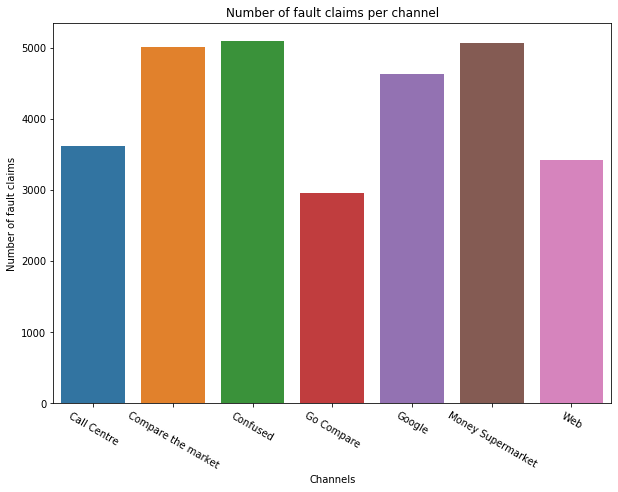

In [21]:
fig = plt.figure(figsize=(10,7))
ax = sns.barplot(x='channel', y='num_fault_claims', data=fault_claims)

ax.set_title('Number of fault claims per channel')
ax.set_xlabel('Channels')
ax.set_ylabel('Number of fault claims')

plt.xticks(rotation=-30)
plt.show()

## Correlation matrix

Let's produce a correlation matrix to see which variables are related with each other

In [22]:
df = df.drop(['yearofbirth', 'age'], axis = 1) 

In [23]:
le = LabelEncoder()
objList = df.select_dtypes(include = ['object', 'datetime64[ns]']).columns
for feat in objList:
    df[feat] = le.fit_transform(df[feat].astype(str))

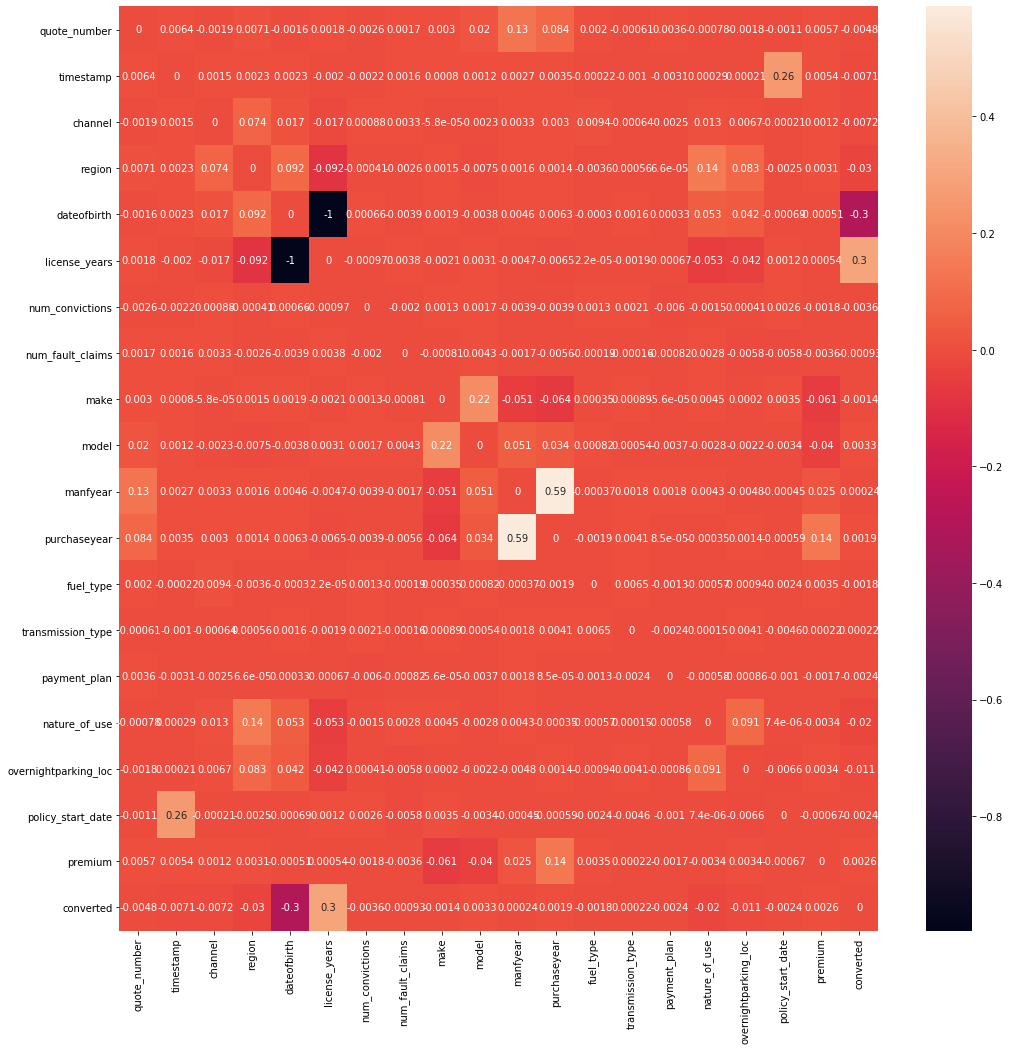

In [24]:
corrMatrix = df.corr()
corrMatrix.replace(1, 0, inplace=True) # the diagonal is going to be equal to 1 anyways
fig = plt.figure(figsize=(17,17))
sns.heatmap(corrMatrix, annot=True)
plt.show()

We remove the values from the diagonal as we know in advance they are equal to 1. By investigating the matrix we do not find many surpises actually. It is expected for the make to be correlated to the model, the purchase and the manifactured year.It is also expected for the date of birth to be inversely correlated to the license years.

## Machine Learning

Let's create a Random Forest model which is a great classifier for large datasets with many features. Our goal is to predict the chance of conversion. As we can see below, conversion happens to roughly a third of the observations.

In [25]:
df['converted'].value_counts()

0    65648
1    34348
Name: converted, dtype: int64

In [26]:
x = np.array(df.loc[:, df.columns != 'converted'])
y = np.array(df['converted'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [27]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [28]:
model = RandomForestClassifier(n_estimators=50, random_state=0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

We can use the MSE and its square root as metrices of error.

In [29]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Squared Error: 0.32746446862026124
Root Mean Squared Error: 0.5722451123603077


In [30]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[18973  2741]
 [ 8065  3220]]
              precision    recall  f1-score   support

           0       0.70      0.87      0.78     21714
           1       0.54      0.29      0.37     11285

    accuracy                           0.67     32999
   macro avg       0.62      0.58      0.58     32999
weighted avg       0.65      0.67      0.64     32999



From the confusion matrix we notice there are many observations falsely classified as 0, which is verified from the low precision value (0.54) of 0 in the classification report. As we can from the accuracy metric, the Random Forest model can correctly predict around the two thirds of the observations, but it is much more accurate when it comes to predicting conversion they occured.